In [229]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'cs231n-project/daniel/'

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
%cd /content/drive/My\ Drive/$FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/cs231n-project/daniel


In [230]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import tqdm.notebook as tq
from time import time

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.style.use('seaborn')
plt.rc('axes', labelsize=17)
plt.rc('xtick', labelsize=17)
plt.rc('ytick', labelsize=17)

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
dtype = torch.float
print(f'device: {device}')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
device: cpu


In [231]:
BATCH_SIZE = 64
NUM_TRAIN = 100
NUM_TEST = 250

# C = number of classes = max(y_train) + 1
D, C = 8*8, 5

def load_dataset():
  X_train = np.load('./datasets/X_ImageNet_8x8_5c_train.npy')    # (6500, 8, 8)
  y_train = np.load('./datasets/y_ImageNet_8x8_5c_train.npy')    # (650, )
  X_test = np.load('./datasets/X_ImageNet_8x8_5c_test.npy')      # (250, 8, 8)
  y_test = np.load('./datasets/y_ImageNet_8x8_5c_test.npy')      # (250, )

  # Normalize
  mean, std = X_train.mean(), X_train.std()
  X_train = (X_train - mean) / std
  X_test = (X_test - mean) / std

  # y labels are numered from 1, we want them from zero
  y_train -= 1
  y_test -= 1

  X_train = X_train[:NUM_TRAIN]
  y_train = y_train[:NUM_TRAIN]
  X_test = X_test[:NUM_TEST]
  y_test = y_test[:NUM_TEST]

  print(f'X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}')
  print(f'X_test.shape: {X_test.shape}, y_train.shape: {y_test.shape}')

  return X_train, y_train, X_test, y_test

def get_datasets():
  X_train, y_train, X_test, y_test = load_dataset()
  X_train = torch.from_numpy(X_train).type(dtype)
  y_train = torch.from_numpy(y_train).long()
  X_test = torch.from_numpy(X_test).type(dtype)
  y_test = torch.from_numpy(y_test).long()
  train_dset = list(zip(X_train, y_train))
  test_dset = list(zip(X_test, y_test))
  return train_dset, test_dset

train_dset, test_dset = get_datasets()

def get_loaders():
  train_loader = DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=False)
  test_loader = DataLoader(test_dset, batch_size=BATCH_SIZE, shuffle=False)
  return train_loader, test_loader

train_loader, test_loader = get_loaders()

X_train.shape: (100, 8, 8), y_train.shape: (100,)
X_test.shape: (250, 8, 8), y_train.shape: (250,)


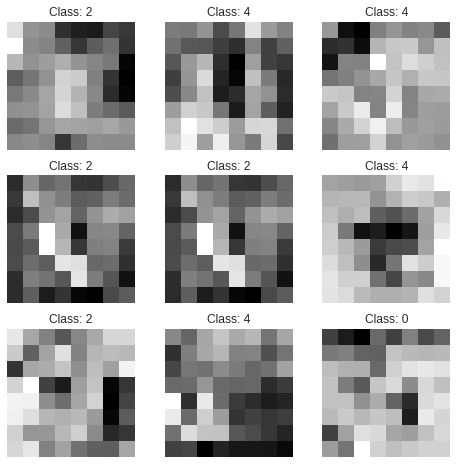

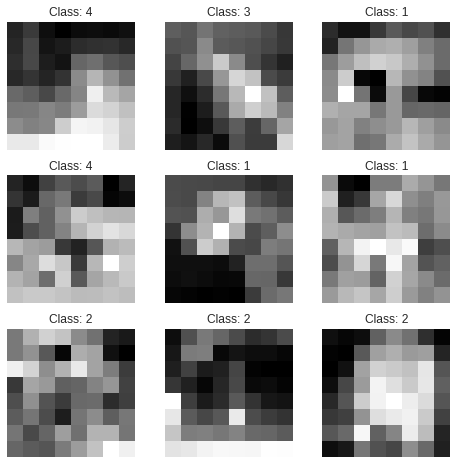

In [188]:
np.random.seed(0)
def visualize_dataset(dset):
  figure = plt.figure(figsize=(8,8))
  cols, rows = 3, 3
  for i in range(1, cols * rows + 1):
    sample_idx = np.random.randint(len(dset))
    img, label = dset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(f'Class: {label}')
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
  plt.show()

visualize_dataset(train_dset)
visualize_dataset(test_dset)

In [241]:
def check_accuracy(loader, model, loss_fn):  
    num_correct, num_samples = 0, 0
    model.eval()
    loss = 0.0
    with torch.no_grad():
        for X, y in loader:
            X = X.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)
            scores = model(X).squeeze()
            loss += loss_fn(scores, y, model, scale_for_SGD=False)
            preds = scores.argmax(dim=1)
            num_correct += (preds == y).sum()
            num_samples += preds.shape[0]
    acc = float(num_correct) / num_samples
    return acc, loss, num_correct, num_samples

def print_stats(iteration, loss, accuracy, num_correct, num_samples):
  print('It: %d, loss: %.3f, acc: %.2f%%, ratio: %d/%d' % (iteration, loss, 100 * accuracy, num_correct, num_samples))

def generator():
  n = 0
  while True:
    yield n
    n += 1

def progress_bar(epochs: int):
  return tq.tqdm(generator()) if epochs == -1 else tq.tqdm(range(epochs))

def get_epochs_iter(epochs: int, verbose: bool):
  if not verbose:
    return progress_bar(epochs)
  elif epochs == -1:
    return generator()
  else:
    return range(epochs)
    

def train(model, loss_fn, optimizer, train_loader,
          acc_check_loader, epochs=1, check_every=None, verbose=False):
  '''
  @param epochs:  If epochs = -1, then train will run until accuracy == 1.0.
  '''
  loss_history, loss_timestamps = [], []
  accuracy_history, accuracy_timestamps = [], []
  done = False

  model = model.to(device=device)
  epochs_iter = get_epochs_iter(epochs, verbose)
  start = time()

  for e in epochs_iter:
    if done:
      break
    if verbose: 
      print(f'### Epoch {e} ###')

    for t, (X, y) in enumerate(train_loader):
      model.train()
      X = X.to(device=device, dtype=dtype)
      y = y.to(device=device, dtype=torch.long)

      # Forward pass
      y_pred = model(X)
      loss = loss_fn(y_pred, y, model, scale_for_SGD=True)
      loss_history.append(loss.item())
      loss_timestamps.append(time() - start)


      # Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if check_every is not None and t % check_every == 0:
        accuracy, loss_all, num_correct, num_samples = check_accuracy(acc_check_loader, model, loss_fn)
        # loss_history.append(loss)
        # loss_timestamps.append(time() - start)
        accuracy_history.append(accuracy)
        accuracy_timestamps.append(time() - start)
        if verbose:
          print_stats(t, loss_all, accuracy, num_correct, num_samples)
        if accuracy == 1.0:
          done = True
          break

  return loss_history, loss_timestamps, accuracy_history, accuracy_timestamps

In [253]:
class Polly(nn.Module):
  def forward(self, x):
    return (0.09 * x**2 + 0.5 * x + 0.47)

class LinearUnitNorm(nn.Module):
  def __init__(self, D, H):
    super(LinearUnitNorm, self).__init__()
    self.W = torch.nn.Parameter(data=torch.normal(mean=0, std=1, size=(D, H), dtype=dtype))
    nn.init.kaiming_normal_(self.W)

  def forward(self, x):
    return x @ (self.W / torch.linalg.norm(self.W, dim=0, keepdim=True))

H = 20
beta = 10

model = nn.Sequential(
    nn.Flatten(),
    LinearUnitNorm(D, H),
    Polly(),
    nn.Linear(H, C, bias=False)
)

def loss_fn(scores, y_labels, model, scale_for_SGD):
  N, C = scores.shape
  Y = torch.zeros((N, C))
  Y[range(N), y_labels] = 1
  second_weights = model.state_dict()['3.weight']
  if scale_for_SGD:
    loss = 0.5 * ((scores - Y)**2).sum() * NUM_TRAIN/y_labels.shape[0] + beta * torch.abs(second_weights).sum()
  else:
    # We are adding the losses over all the dataset, so compute loss as normal
    loss = 0.5 * ((scores - Y)**2).sum() + beta * torch.abs(second_weights).sum() * y_labels.shape[0]/NUM_TRAIN
  return loss

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# optimizer = torch.optim.SGD(model.parameters(), lr=10**(-5), momentum=0.9)
loss_history, loss_timestamps, accuracy_history, accuracy_timestamps = train(model, loss_fn, optimizer, train_loader,
                                       acc_check_loader=train_loader, epochs=1500, 
                                       check_every=2, verbose=False)

Loss and accuracy



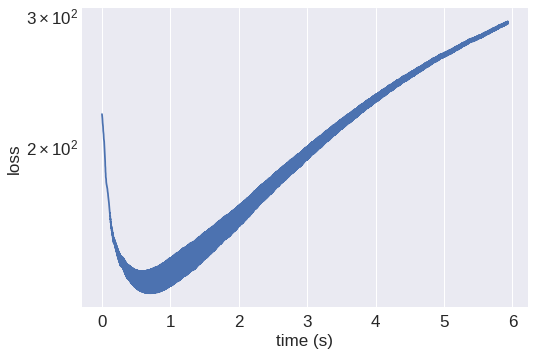

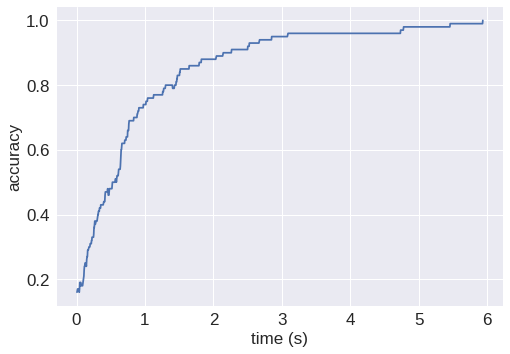

Average Loss and average accuracy


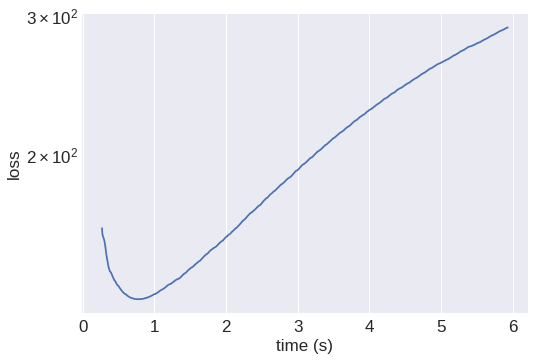

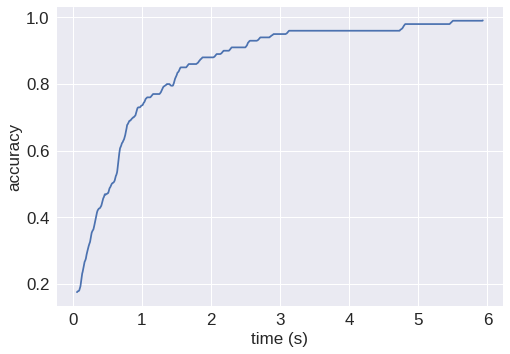

In [254]:
print('Loss and accuracy')
plt.semilogy(loss_timestamps, loss_history)
plt.ylabel(r'loss')
plt.xlabel(r'time (s)')
plt.show()
plt.plot(accuracy_timestamps, accuracy_history)
plt.ylabel('accuracy')
plt.xlabel('time (s)')
plt.show()

def moving_average(a: np.array, n: int) :
  ret = np.cumsum(a, dtype=float)
  ret[n:] = ret[n:] - ret[:-n]
  return ret[n - 1:] / n

print('Average Loss and average accuracy')
window = 100
plt.semilogy(loss_timestamps[window-1:], moving_average(loss_history, window))
plt.ylabel(r'loss')
plt.xlabel(r'time (s)')
plt.show()
window = 10
plt.plot(accuracy_timestamps[window-1:], moving_average(accuracy_history, window))
plt.ylabel('accuracy')
plt.xlabel('time (s)')
plt.show()

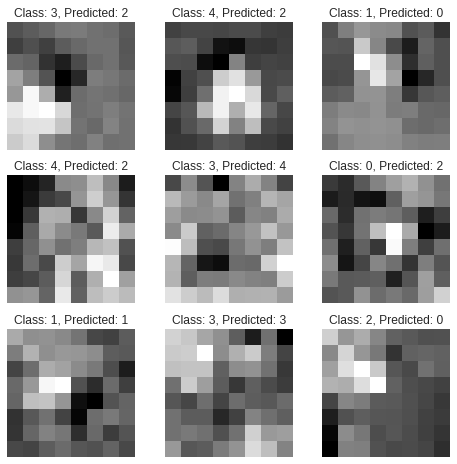

In [170]:
def visualize_predictions(dset_loader, model):
  X, y = next(iter(dset_loader))
  scores = model(X)
  y_preds = scores.argmax(dim=1)
  figure = plt.figure(figsize=(8,8))
  cols, rows = 3, 3
  for i in range(1, cols * rows + 1):
    sample_idx = np.random.randint(len(X))
    img, label, pred_label = X[sample_idx], y[sample_idx], y_preds[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(f'Class: {label}, Predicted: {pred_label}')
    plt.axis("off")
    plt.imshow(img, cmap="gray")
  plt.show()

visualize_predictions(test_loader, model)